# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Знакомство с данными

In [42]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

In [2]:
pd.set_option('mode.chained_assignment', None)

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


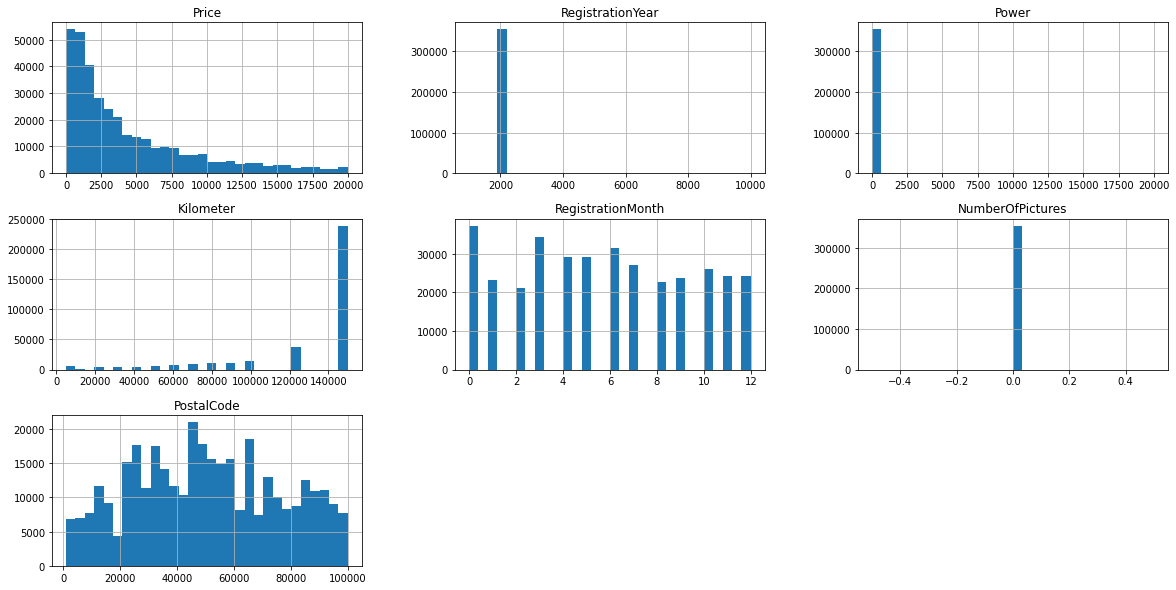

In [4]:
df.hist(figsize = (20,10), bins = 30);

In [5]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
df.duplicated().sum()

4

In [7]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [8]:
df.RegistrationYear.value_counts()

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 151, dtype: int64

In [9]:
df.RegistrationMonth.value_counts()

0     37352
3     34373
6     31507
4     29270
5     29153
7     27211
10    26099
12    24289
11    24186
9     23813
1     23218
8     22627
2     21267
Name: RegistrationMonth, dtype: int64

1050.0 14600.0


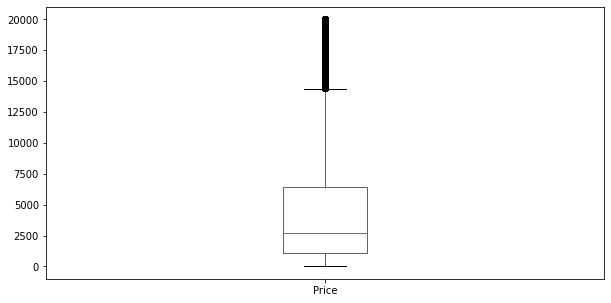

In [10]:
df.Price.plot(kind = 'box', figsize = (10,5))
print(df.Price.quantile(0.25), df.Price.quantile(0.95))

In [11]:
print(df.Power.quantile(0.25), df.Power.quantile(0.75))

69.0 143.0


**Вывод**:
1. Данные открыты и изучены
2. Много пропусков в столбцах: **VehicleType, Gearbox, Model, FuelType, Repaired**. В категориальных признаках можно заменить пропуски модой, самым часто встречающимся значением в столбце
3. Дубликатов найдено 4 штуки, удалили их
4. В столбце **RegistrationYear** обнаружены значения меньше 1950 и больше 2023. На следующем этапе удалим эти выбросы
5. В столбце **RegistrationMonth** присутствует значение 0, но нету 1. Заменим все нули на единицы
6. В столбцах **Power** и **Price** есть выбросы

### Предобработка

**Заполним модой пропуски в категориальных признаках:**

In [12]:
columns = ['Gearbox', 'FuelType', 'Repaired', 'VehicleType', 'Model']

for column in columns:
    df[column] = df[column].fillna('None')
    
    
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

**Удалим выбросы:**

In [13]:
df = df[(df['RegistrationYear'] > 1950) & (df['RegistrationYear'] < 2017)]

In [14]:
df = df[df['Price'] > 0]
df = df[df['Power'] < 700]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,None,1993,manual,0,golf,150000,0,petrol,volkswagen,None,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,None,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,None,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354365,2016-03-14 17:48:27,2200,None,2005,None,0,None,20000,1,None,sonstige_autos,None,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


**Уберем ненужные колонки:**

In [15]:
df = df.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode", "RegistrationMonth"],axis = 1)

**Посмотрим на корреляцию признаков с целевым:**

In [16]:
df.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.450441,0.491401,-0.354369
RegistrationYear,0.450441,1.000000,0.152562,-0.233961
Power,0.491401,0.152562,1.000000,0.081796
Kilometer,-0.354369,-0.233961,0.081796,1.000000


**Вывод:**
1. Ознакомились с данными и их распределениями
2. Удалили дубликаты
3. Заполнили пропуски в категориальных признаках модой
4. Удалили выбросы
5. Удалили ненужные для обучения модели столбцы 
6. Посмотрели корреляцию признаков: самая сильная положительная корреляция с ценой у мощности автомобиля, отрицательная – с пробегом

## Разделим и закодируем выборки

Краткий план по выполнению этого раздела:
   1. Разделим выборки на тренировочную, валидационную и тестовую
   2. Преобразуем категориальные признаки (в которых не так много значений) **OHE** способом –– колонки **VehicleType, GearBox, FuelType, Repaired**
   3. Преобразуем остальные категориальные признаки с помощью **MEstimateEncoder** –– колонки **Brand, Model**
   4. Количественные признаки стандартизируем с помощью **StandardScaler** –– колонки **Kilometer, Power**

### Разделим выборки

In [17]:
features_train , target_train , features_valid , target_valid , features_test, target_test = train_valid_test_split(
df , target = 'Price', train_size = 0.6, valid_size = 0.2, test_size = 0.2, random_state = 12345)

Отдельно запишем функции для преобразования признаков для **StandardScaler, OHE, MEstimatorEncoder**:

In [18]:
def features_transform_scaler(type_encoding, type_feature, cols):
    return pd.DataFrame(data = type_encoding.transform(type_feature[cols]),
                        columns = cols,
                        index = type_feature.index
                       )


def features_transform_ohe(type_encoding, type_feature, cols):
    return pd.DataFrame(data = type_encoding.transform(type_feature[cols]),
                        columns = type_encoding.get_feature_names(cols),
                        index = type_feature[cols].index
                       )

def features_transform_me(type_encoding, type_feature, cols):
    return pd.DataFrame(data = type_encoding.transform(type_feature[cols]),
                        columns = type_encoding.get_feature_names_out(cols),
                        index = type_feature[cols].index
                       )

### OHE

Закодируем методом OHE только те категориальные признаки, в которых встречается мало значений, чтобы не допустить "проклятья размерности" ;)

In [56]:
encoder = OneHotEncoder(sparse = False)
columns_ohe = ['VehicleType','Gearbox','FuelType','Repaired']
encoder.fit(features_train[columns_ohe])
features = [features_train, features_valid, features_test]

encoded_features_train = features_transform_ohe(encoder, features_train, columns_ohe)
encoded_features_valid = features_transform_ohe(encoder, features_valid, columns_ohe)
encoded_features_test = features_transform_ohe(encoder, features_test, columns_ohe)

encoded_features_test.head()

,VehicleType_None,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_None,...,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_None,Repaired_no,Repaired_yes
58654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
303415,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
259160,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
192483,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
50210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### MEstimate Encoding

In [20]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [21]:
from category_encoders.m_estimate import MEstimateEncoder

In [22]:
encoder = MEstimateEncoder()
columns_me = ['Brand', 'Model']
encoder.fit(features_train[columns_me], target_train)
features_train_me = features_transform_me(encoder, features_train, columns_me)
features_valid_me = features_transform_me(encoder, features_valid, columns_me)
features_test_me = features_transform_me(encoder, features_test, columns_me)

features_test_me.head()

,Brand,Model
58654,4511.704599,11605.164120
303415,3559.261573,3640.042911
259160,4585.987736,2651.957372
192483,3894.170239,3934.276150
50210,3698.021293,6311.651496


### StandardScaler (Стандартизируем Признаки)

In [23]:
columns = ['Kilometer', 'Power']
scaler = StandardScaler()
scaler.fit(features_train[columns])
features_train_scaler = features_transform_scaler(scaler, features_train, columns)
features_valid_scaler = features_transform_scaler(scaler, features_valid, columns)
features_test_scaler = features_transform_scaler(scaler, features_test, columns)

features_test_scaler.head()

,Kilometer,Power
58654,0.581465,1.215631
303415,0.581465,-1.074323
259160,-0.086133,-1.726324
192483,-1.287810,-0.231493
50210,0.581465,1.295143


In [34]:
features_train_new = pd.DataFrame(index = encoded_features_train.index)
features_train_new['RegistrationYear'] = features_train['RegistrationYear']
features_train_new['Kilometer'] = features_train_scaler['Kilometer']
features_train_new['Power'] = features_train_scaler['Power']
features_train_new['Model'] = features_train_me['Model']
features_train_new['Brand'] = features_train_me['Brand']

features_train_new = pd.merge(features_train_new, encoded_features_train, on = features_train_new.index)
features_train_new = features_train_new.drop('key_0', axis = 1)
# features_train_new 
# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
features_valid_new = pd.DataFrame(index = encoded_features_valid.index)
features_valid_new['RegistrationYear'] = features_valid['RegistrationYear']
features_valid_new['Kilometer'] = features_valid_scaler['Kilometer']
features_valid_new['Power'] = features_valid_scaler['Power']
features_valid_new['Model'] = features_valid_me['Model']
features_valid_new['Brand'] = features_valid_me['Brand']

features_valid_new = pd.merge(features_valid_new, encoded_features_valid, on = features_valid_new.index)
features_valid_new = features_valid_new.drop('key_0', axis = 1)
# features_valid_new 
# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
features_test_new = pd.DataFrame(index = encoded_features_test.index)
features_test_new['RegistrationYear'] = features_test['RegistrationYear']
features_test_new['Kilometer'] = features_test_scaler['Kilometer']
features_test_new['Power'] = features_test_scaler['Power']
features_test_new['Model'] = features_test_me['Model']
features_test_new['Brand'] = features_test_me['Brand']

features_test_new = pd.merge(features_test_new, encoded_features_test, on = features_test_new.index)
features_test_new = features_test_new.drop('key_0', axis = 1)
# features_test_new


,RegistrationYear,Kilometer,Power,Model,Brand,VehicleType_None,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,...,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_None,Repaired_no,Repaired_yes
0,2006,0.581465,1.215631,11605.164120,4511.704599,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2004,0.581465,-1.074323,3640.042911,3559.261573,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1993,-0.086133,-1.726324,2651.957372,4585.987736,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,2011,-1.287810,-0.231493,3934.276150,3894.170239,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1994,0.581465,1.295143,6311.651496,3698.021293,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65859,2007,-1.020771,-0.104273,7396.215729,4145.789585,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
65860,1998,0.581465,-0.581347,4366.341426,4585.987736,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
65861,1992,0.581465,0.659045,3235.982269,6402.988860,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
65862,2009,-0.086133,0.181971,9963.314230,9212.783127,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


## Обучение моделей

### LinearRegression

In [36]:
import time

In [48]:
start = time.time()
model_lin = LinearRegression()

model_lin.fit(features_train_new, target_train)
mse_lin = mean_squared_error(model_lin.predict(features_valid_new), target_valid)
end = time.time()
print(end - start)

0.5025837421417236


### Light GBM

In [45]:
start = time.time()
lgbm = LGBMRegressor()
lgbm.fit(features_train_new, target_train)
mse_lgbm = mean_squared_error(lgbm.predict(features_valid_new), target_valid)
end = time.time()
end - start

183.42543935775757

### Cat Boost

In [58]:
start = time.time()
model = CatBoostRegressor() 
parameters = [{'learning_rate':[0.1,0.4,0.9], 'random_state':[12345], 'verbose':[False]}]

model_grid = GridSearchCV(model, parameters, scoring='neg_mean_squared_error')
model_grid.fit(features_train_new, target_train)
mse_catboost = mean_squared_error(model_grid.predict(features_valid_new), target_valid)
print(model_grid.best_params_)
end = time.time()
end - start

{'learning_rate': 0.4, 'random_state': 12345, 'verbose': False}


317.39153242111206

**Вывод по 3 пункту:**
Модель линейной регрессии обучается за 0,5 сек, LightGBM –– 183, CatBoost –– 317. Проанализируем характеристику **RMSE** у моделей:

## Анализ моделей

In [49]:
start = time.time()
print(mse_lin**0.5)
end = time.time()
end - start

2798.664530039228


0.00015354156494140625

In [50]:
start = time.time()
print(mse_catboost**0.5)
end = time.time()
end - start

1574.1505674417776


0.00021767616271972656

In [51]:
start = time.time()
print(mse_lgbm**0.5)
end = time.time()
end - start

1687.7052561802393


0.00013828277587890625

Лучшая модель по RMSE –– Catboost. Проверим ее на тестовой выборке:

In [53]:
mean_squared_error(model_grid.predict(features_test_new), target_test)**0.5

1590.2591254551842